In [2]:
# import libraries
import numpy as np
from scipy import stats as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels as sm
import sklearn as skl
import sklearn.metrics as skm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# access files stored on Google Drive from Colab
#from google.colab import drive
#drive.mount('gdrive/')

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# read in datasets
glmTest = pd.read_csv("glm.test.data.csv")
glmTrain = pd.read_csv("glm.training.data.csv")
testOnsetini = pd.read_csv("test.onsets.csv")
testTSini = pd.read_csv("timestamps.test.csv")

# create duplicates of datasets
testTS=testTSini
testOnset=testOnsetini
glmTrain2=glmTrain

# filtering out bpm <=20 or > 500, since lowest and highest ventricular heart rate ever recorded is 28 and 480 respectively
glmTrain2=glmTrain2.drop(glmTrain2[(glmTrain2['x.hr']<=20) | (glmTrain2['x.hr']>500)].index) 
# filter out duplicate data from same sample
#keys=glmTrain2.keys().drop('Unnamed: 0','y').tolist()
#glmTrain2=glmTrain2.groupby(keys).mean().reset_index(level=list(range(0,len(keys))))
# filter fahrenheit: highest recorded 114F (45C) lowest 57F
glmTrain2['x.temp']=np.where(glmTrain2['x.temp']>50, (glmTrain2['x.temp']-32)*5/9, glmTrain2['x.temp'])

# normalize data
scaler = skl.preprocessing.StandardScaler()
x_train = glmTrain2.drop(["Unnamed: 0","y"],axis=1)
x_trainDM = scaler.fit_transform(glmTrain2.drop(["Unnamed: 0","y"],axis=1))
y_train=glmTrain2["y"].values

# make empty AUC array to store lambda and AUC values
allAUC=[]
g_allAUC=[]

In [28]:
glmTest['patient'].shape

(381692,)

In [16]:
# create duplicates of datasets
glmTest2=glmTest

# filtering out bpm <=20 or > 500, since lowest and highest ventricular heart rate ever recorded is 28 and 480 respectively
glmTest2=glmTest2.drop(glmTest2[(glmTest2['hr']<=20) | (glmTest2['hr']>500)].index) 
# filter out duplicate data from same sample
#keys=glmTrain2.keys().drop('Unnamed: 0','y').tolist()
#glmTrain2=glmTrain2.groupby(keys).mean().reset_index(level=list(range(0,len(keys))))
# filter fahrenheit: highest recorded 114F (45C) lowest 57F
glmTest2['temp']=np.where(glmTest2['temp']>50, (glmTest2['temp']-32)*5/9, glmTest2['temp'])

# normalize data
scaler = skl.preprocessing.StandardScaler()
x_test = glmTest2.drop(["Unnamed: 0","y"],axis=1)
x_testDM = scaler.fit_transform(glmTest2.drop(["Unnamed: 0","y","patient"],axis=1))
y_test=glmTest2["y"].values

Now testing lambda =  0.1
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4
Now at fold  5
Now at fold  6
Now at fold  7
Now at fold  8
Now at fold  9


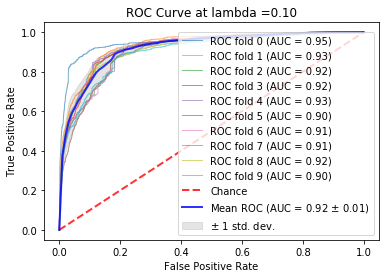

Now testing lambda =  1.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4
Now at fold  5
Now at fold  6
Now at fold  7
Now at fold  8
Now at fold  9


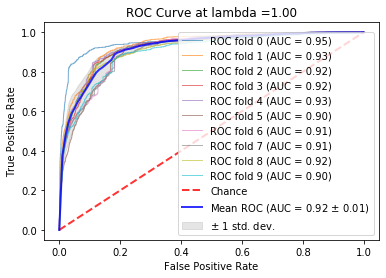

Now testing lambda =  10.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4
Now at fold  5
Now at fold  6
Now at fold  7
Now at fold  8
Now at fold  9


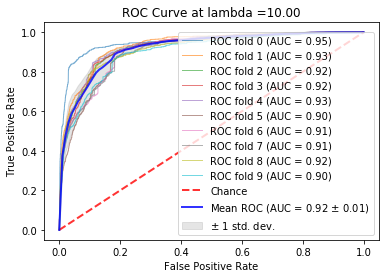

Now testing lambda =  100.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4
Now at fold  5
Now at fold  6
Now at fold  7
Now at fold  8
Now at fold  9


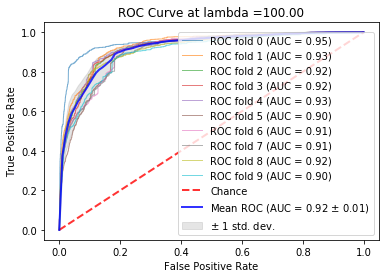

Now testing lambda =  1000.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4
Now at fold  5
Now at fold  6
Now at fold  7
Now at fold  8
Now at fold  9


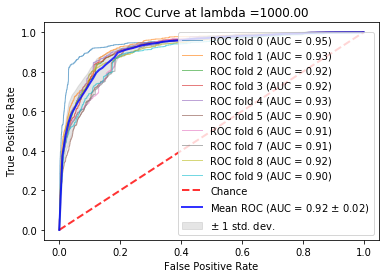

Now testing lambda =  10000.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4
Now at fold  5
Now at fold  6
Now at fold  7
Now at fold  8
Now at fold  9


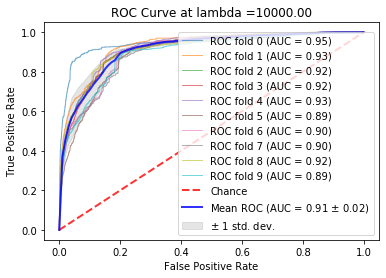

Now testing lambda =  100000.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4
Now at fold  5
Now at fold  6
Now at fold  7
Now at fold  8
Now at fold  9


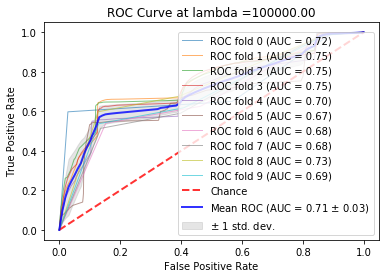

Now testing lambda =  1000000.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4
Now at fold  5
Now at fold  6
Now at fold  7
Now at fold  8
Now at fold  9


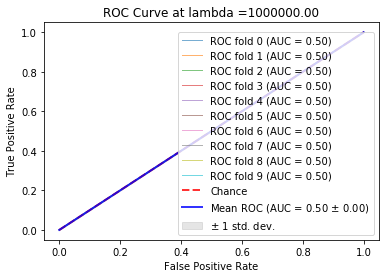

Now testing lambda =  10000000.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4
Now at fold  5
Now at fold  6
Now at fold  7
Now at fold  8
Now at fold  9


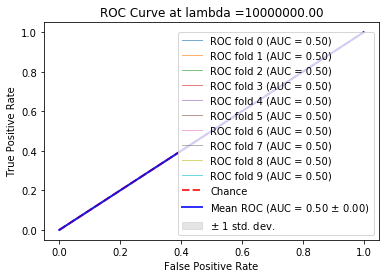

Now testing lambda =  100000000.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4
Now at fold  5
Now at fold  6
Now at fold  7
Now at fold  8
Now at fold  9


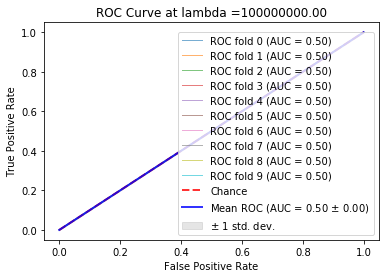

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# models.crossvalidation.kfold
# LogisticRegressionCV

# c = regularization strength, c = 1/lambda

k_fold = KFold(n_splits=10) # throws error when only all 0 or all 1 in training y set, so use stratified instead
skf = StratifiedKFold(n_splits=10) # The folds are made by preserving the percentage of samples for each class.

# spliting up data biases model i.e. not random profiles, cross-validation compares outcomes over diff data to account for bias over the multiple sets 
for lamb in np.logspace(-1, 8, 10):
    print("Now testing lambda = ", lamb)
    logreg = LogisticRegression(C=1/lamb,penalty='l1', tol=0.01, solver='saga', max_iter=200)

    tprs = []
    aucs = []
    accs = []
    mean_fpr = np.linspace(0, 1, 100)
  
    i=0

    for train, test in skf.split(x_trainDM,y_train):
        print("Now at fold ", i)
        mod = logreg.fit(x_trainDM[train], y_train[train])
        probas_ = mod.predict_proba(x_trainDM[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = skm.roc_curve(y_train[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = skm.roc_auc_score(y_train[test],probas_[:,1])
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.6,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        accs.append(skm.accuracy_score(y_train[test], mod.predict(x_trainDM[test])))
        i += 1

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = skm.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve at lambda =%0.2f' % lamb)
    plt.legend(loc="lower right")
    plt.show()
    
    allAUC.append([lamb, mean_auc,np.mean(accs)])

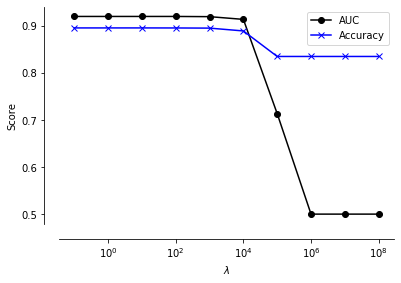

In [22]:
# plot lambda, scores, and selected optimal value
AUC=np.array(allAUC)

AUC=AUC[AUC[:,0].argsort()]

plt.plot(AUC[:,0], AUC[:,1], '-ko')
plt.plot(AUC[:,0], AUC[:,2], '-bx')
plt.xlabel(r'$\lambda$')
#plt.axhline(lassocv_score, color='b', ls='--')
#plt.axvline(lassocv_alpha, color='b', ls='--')
plt.ylabel('Score')
plt.xscale('log')
plt.legend(('AUC','Accuracy'))
sns.despine(offset=15)

Now testing lambda =  10000.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


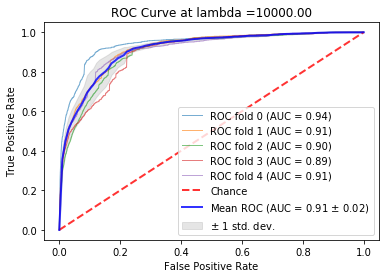

Now testing lambda =  16681.005372000593
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


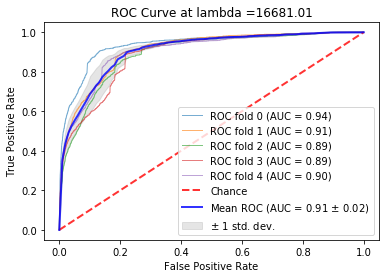

Now testing lambda =  27825.59402207126
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


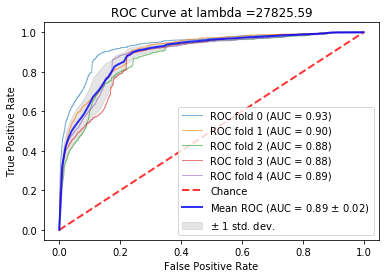

Now testing lambda =  46415.88833612782
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


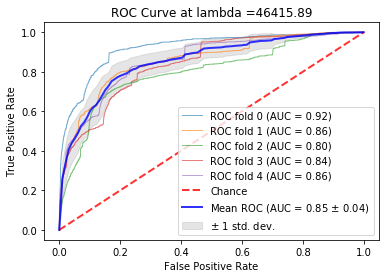

Now testing lambda =  77426.36826811278
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


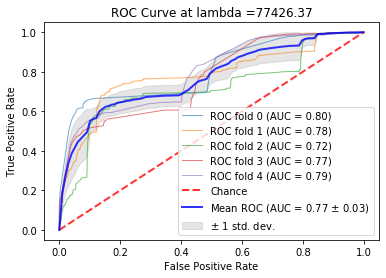

Now testing lambda =  129154.96650148826
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


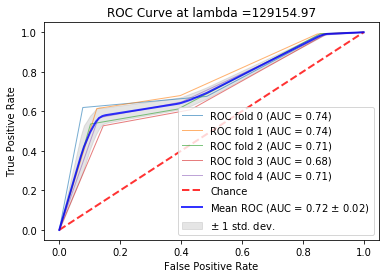

Now testing lambda =  215443.46900318822
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


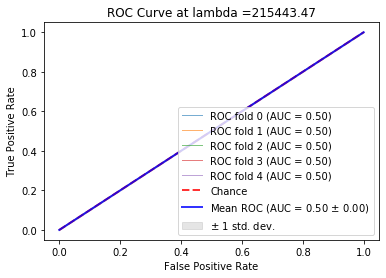

Now testing lambda =  359381.36638046254
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


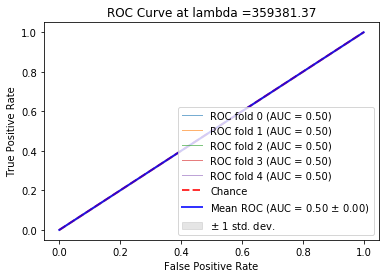

Now testing lambda =  599484.2503189408
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


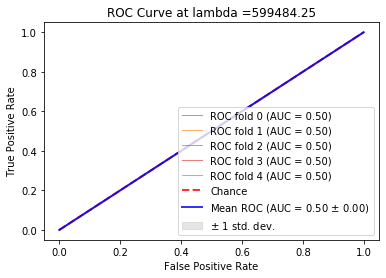

Now testing lambda =  1000000.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


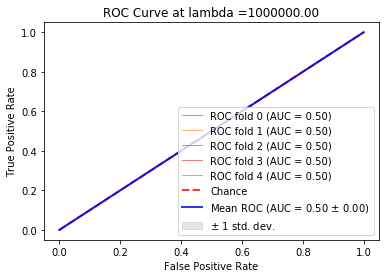

In [12]:
# run another round of optimization, between the values of 10^4 and 10^6
# spliting up data biases model i.e. not random profiles, cross-validation compares outcomes over diff data to account for bias over the multiple sets 
for lamb in np.logspace(4, 6, 10):  
    print("Now testing lambda = ", lamb)
    logreg = LogisticRegression(C=1/lamb,penalty='l1', tol=0.01, solver='saga', max_iter=200)

    tprs = []
    aucs = []
    accs = []
    mean_fpr = np.linspace(0, 1, 100)
  
    i=0

    for train, test in skf.split(x_trainDM,y_train):
        print("Now at fold ", i)
        mod = logreg.fit(x_trainDM[train], y_train[train])
        probas_ = mod.predict_proba(x_trainDM[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = skm.roc_curve(y_train[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = skm.roc_auc_score(y_train[test],probas_[:,1])
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.6,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        accs.append(skm.accuracy_score(y_train[test], mod.predict(x_trainDM[test])))
        i += 1

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = skm.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve at lambda =%0.2f' % lamb)
    plt.legend(loc="lower right")
    plt.show()
    
    allAUC.append([lamb, mean_auc,np.mean(accs)])

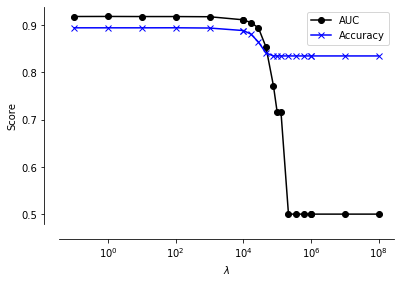

In [280]:
# plot lambda, scores, and selected optimal value
AUC=np.array(allAUC)

AUC=AUC[AUC[:,0].argsort()]

plt.plot(AUC[:,0], AUC[:,1], '-ko')
plt.plot(AUC[:,0], AUC[:,2], '-bx')
plt.xlabel(r'$\lambda$')
#plt.axhline(lassocv_score, color='b', ls='--')
#plt.axvline(lassocv_alpha, color='b', ls='--')
plt.ylabel('Score')
plt.xscale('log')
plt.legend(('AUC','Accuracy'))
sns.despine(offset=15)

In [285]:
# lambda alpha (1.00000000e+04) is optimal lambda
optiLamb=1.00000000e+04

logreg = LogisticRegression(C=1/optiLamb,penalty='l1', tol=0.01, solver='saga', max_iter=200)
mod = logreg.fit(x_trainDM, y_train)

Accuracy:  0.8906185063997751


,keys,coef
17,x.paco2,-0.040177
8,x.fio2,0.048931
22,x.resp.sofa,0.056202
1,x.sbp,-0.088602
4,x.resp,0.098576
25,x.liver.sofa,0.102080
3,x.mbp,-0.140928
7,x.pao2,0.152994
0,x.hr,0.262203
21,x.urine,-0.358411


In [14]:
probas_ = mod.predict_proba(x_trainDM)

# Compute ROC curve and area the curve
fpr, tpr, thresholds = skm.roc_curve(y_train, probas_[:, 1])
roc_auc = skm.roc_auc_score(y_train,probas_[:,1])

# find shortest distance to tpr=1,fpr=0 to determine optimal threshold
roc_values=np.transpose(np.vstack((fpr,tpr)))
dist=np.empty((roc_values.shape[0],1))
for i in range(0,roc_values.shape[0]):
    dist[i]=np.linalg.norm((0,1)-roc_values[i])
x_coord = roc_values[np.argmin(dist)][0]
y_coord = roc_values[np.argmin(dist)][1]

# plot ROC curve
plt.plot(fpr, tpr, lw=1, label='Optimized AUC = %0.2f' % (roc_auc))
plt.plot(x_coord,y_coord,color='k',marker='o',linestyle="None",label='Operating Point')
plt.text(x_coord, y_coord, '({}, {})'.format(round(x_coord,5), round(y_coord,5)))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for training data at optimal lambda =%0.2f' % optiLamb)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.show()

print("Accuracy: ", skm.accuracy_score(y_train, mod.predict(x_trainDM)))
print("AUC: ", roc_auc)
helps2=pd.DataFrame()
helps2['keys']=x_train.keys()
helps2['coef']=mod.coef_[0]
helps3=helps2.drop(helps2[helps2["coef"]==0].index,axis=0)
helps3.sort_values("coef")

helps3.iloc[helps3['coef'].abs().argsort()]

NameError: name 'mod' is not defined

In [293]:
testProbas_ = mod.predict_proba(x_testDM)

# Compute ROC curve and area the curve
test_roc_auc = skm.roc_auc_score(y_test,testProbas_[:,1])

print("For testing set")
print("Accuracy: ", skm.accuracy_score(y_test, mod.predict(x_testDM)))
print("AUC: ", test_roc_auc)
print("PPV: ", np.sum(y_test)/np.sum(mod.predict(x_testDM)))


For testing set
Accuracy:  0.7225943220707619
AUC:  0.6057094243040221


In [9]:
#moving on to part e
testOnset = testOnsetini

optimalIndex = np.where((fpr == x_coord) & (tpr == y_coord))
optimalThreshold = thresholds[optimalIndex][0]

# first, apply model to testing data
y_testPred=mod.predict(x_testDM)
y_testPred[y_testPred>optimalThreshold]=1

# filter data to find patients with both predicted AND actual y = 1
glmTest_filt=glmTest2[['patient','y']]
glmTest_filt['y_pred'] = np.array(y_testPred)
glmTest_filt['TS']=testTSini['x']
glmTest_SepticShock=glmTest_filt[(glmTest_filt['y_pred']==1)&(glmTest_filt['y']==1)].groupby('patient').first()
glmTest_SepticShock['patient'] = glmTest_SepticShock.index

# convert strings to datetime
from datetime import datetime
from dateutil.parser import parse

# concat measurement timestamp to glmTest_SepticShock
glmTest_SepticShock['TS']=[i.replace(year=2020,month=10,day=17) for i in [parse(x) for x in glmTest_SepticShock['TS'].values]]
#,month=10,day=17

# concat actual onset timestamp to glmTest_SepticShock
glmAllSeptic=glmTest2[glmTest2['y']==1].groupby('patient').first()
glmAllSeptic['patient'] = glmAllSeptic.index
glmAllSeptic = glmAllSeptic.reset_index(drop=True)
testOnset = testOnset.reset_index(drop=True)
testOnset = testOnset.join(glmAllSeptic['patient'])
glmTest_SepticShock['Onset']=[testOnset.iloc[list(np.where(testOnset['patient'] == x)[0])[0],1] for x in glmTest_SepticShock['patient'].values]
glmTest_SepticShock['Onset']=[i.replace(year=2020,month=10,day=17) for i in [parse(x) for x in glmTest_SepticShock['Onset'].values]]

# find difference between measurement TS and onset TS
glmTest_SepticShock.reset_index(drop=True)
glmTest_SepticShock['EWT']=[(glmTest_SepticShock.iloc[x,4]-glmTest_SepticShock.iloc[x,2]).total_seconds()/(60*60) for x in range(0,len(glmTest_SepticShock))]
#glmTest_SepticShock['EWT']=np.where(glmTest_SepticShock['EWT']<0, 0, glmTest_SepticShock['EWT'])
glmTest_SepticShock = glmTest_SepticShock.drop(glmTest_SepticShock[glmTest_SepticShock['EWT'] < 0].index)
plt.hist(glmTest_SepticShock['EWT'].values,bins=range(0,50,5))
plt.xlim([0,48])
plt.title("Histogram of EWT")
plt.xlabel("Early Warning Time (hours)")
plt.ylabel("Frequency")
plt.axvline(np.median(glmTest_SepticShock['EWT'].values), color='k', linestyle='dashed', linewidth=1)


NameError: name 'fpr' is not defined

In [ ]:
# part (g) now WITHOUT data balancing

Now testing lambda =  0.1
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


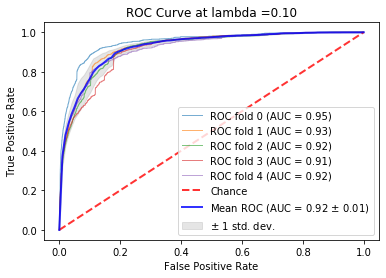

Now testing lambda =  1.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


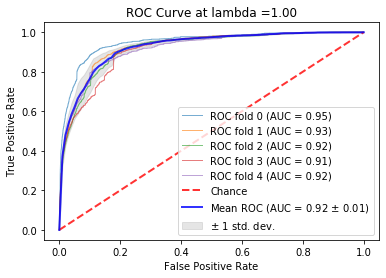

Now testing lambda =  10.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


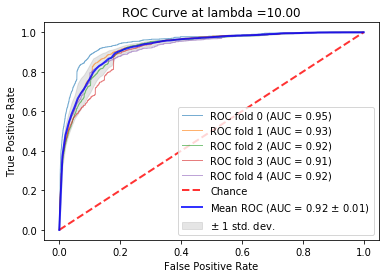

Now testing lambda =  100.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


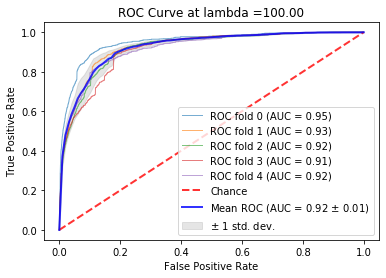

Now testing lambda =  1000.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


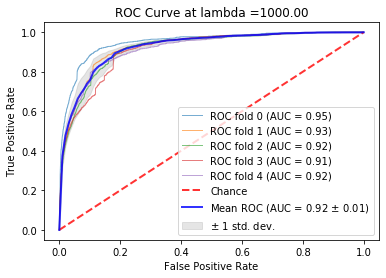

Now testing lambda =  10000.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


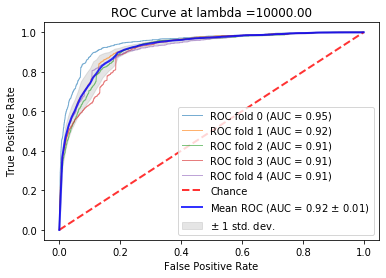

Now testing lambda =  100000.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


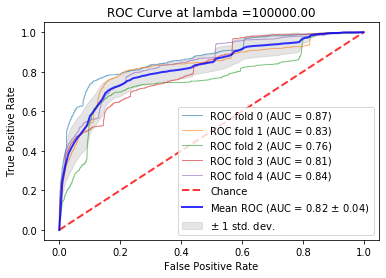

Now testing lambda =  1000000.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


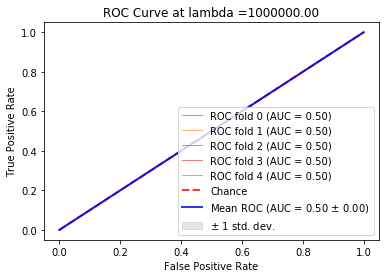

Now testing lambda =  10000000.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


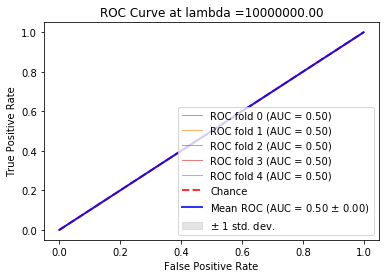

Now testing lambda =  100000000.0
Now at fold  0
Now at fold  1
Now at fold  2
Now at fold  3
Now at fold  4


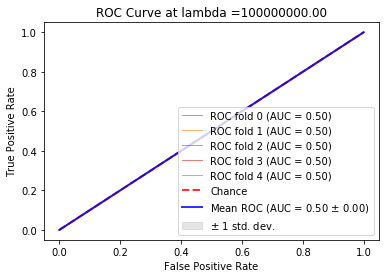

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# models.crossvalidation.kfold
# LogisticRegressionCV

# c = regularization strength, c = 1/lambda

k_fold = KFold(n_splits=5) # throws error when only all 0 or all 1 in training y set, so use stratified instead
skf = StratifiedKFold(n_splits=5) # The folds are made by preserving the percentage of samples for each class.

# spliting up data biases model i.e. not random profiles, cross-validation compares outcomes over diff data to account for bias over the multiple sets 
for lamb in np.logspace(-1, 8, 10):
    print("Now testing lambda = ", lamb)
    g_logreg = LogisticRegression(C=1/lamb,penalty='l1', tol=0.01, solver='saga', max_iter=200,class_weight='balanced')

    g_tprs = []
    g_aucs = []
    g_accs = []
    g_mean_fpr = np.linspace(0, 1, 100)
  
    i=0

    for train, test in skf.split(x_trainDM,y_train):
        print("Now at fold ", i)
        g_mod = g_logreg.fit(x_trainDM[train], y_train[train])
        g_probas_ = g_mod.predict_proba(x_trainDM[test])
        # Compute ROC curve and area the curve
        g_fpr, g_tpr, g_thresholds = skm.roc_curve(y_train[test], g_probas_[:, 1])
        g_tprs.append(np.interp(g_mean_fpr, g_fpr, g_tpr))
        g_tprs[-1][0] = 0.0
        g_roc_auc = skm.roc_auc_score(y_train[test],g_probas_[:,1])
        g_aucs.append(g_roc_auc)
        plt.plot(g_fpr, g_tpr, lw=1, alpha=0.6,label='ROC fold %d (AUC = %0.2f)' % (i, g_roc_auc))
        g_accs.append(skm.accuracy_score(y_train[test], g_mod.predict(x_trainDM[test])))
        i += 1

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)

    g_mean_tpr = np.mean(g_tprs, axis=0)
    g_mean_tpr[-1] = 1.0
    g_mean_auc = skm.auc(g_mean_fpr, g_mean_tpr)
    g_std_auc = np.std(g_aucs)
    plt.plot(g_mean_fpr, g_mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (g_mean_auc, g_std_auc),
          lw=2, alpha=.8)

    g_std_tpr = np.std(g_tprs, axis=0)
    g_tprs_upper = np.minimum(g_mean_tpr + g_std_tpr, 1)
    g_tprs_lower = np.maximum(g_mean_tpr - g_std_tpr, 0)
    plt.fill_between(g_mean_fpr, g_tprs_lower, g_tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve at lambda =%0.2f' % lamb)
    plt.legend(loc="lower right")
    plt.show()
    
    g_allAUC.append([lamb, g_mean_auc,np.mean(g_accs)])

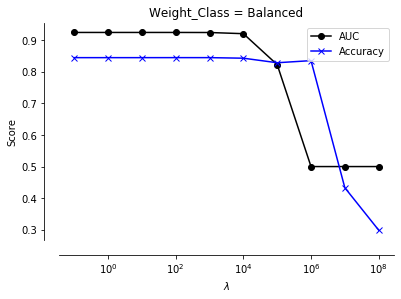

In [7]:
# plot lambda, scores, and selected optimal value
g_AUC=np.array(g_allAUC)

g_AUC=g_AUC[g_AUC[:,0].argsort()]

plt.plot(g_AUC[:,0], g_AUC[:,1], '-ko')
plt.plot(g_AUC[:,0], g_AUC[:,2], '-bx')
plt.xlabel(r'$\lambda$')
#plt.axhline(lassocv_score, color='b', ls='--')
#plt.axvline(lassocv_alpha, color='b', ls='--')
plt.ylabel('Score')
plt.xscale('log')
plt.legend(('AUC','Accuracy'))
plt.title("Weight_Class = Balanced")
sns.despine(offset=15)

In [12]:
# lambda alpha (1.00000000e+04) is optimal lambda
g_optiLamb=1.00000000e+04

g_logreg = LogisticRegression(C=1/g_optiLamb,penalty='l1', tol=0.01, solver='saga', max_iter=200)
g_mod = g_logreg.fit(x_trainDM, y_train)

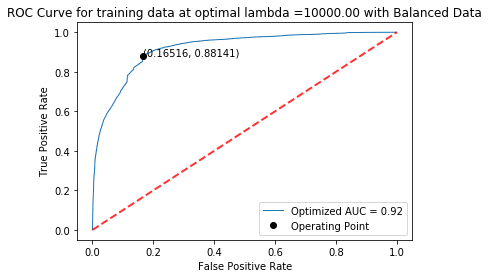

Accuracy:  0.8906026441702182
AUC:  0.9188555494122238


,keys,coef
17,x.paco2,-0.040167
8,x.fio2,0.048868
22,x.resp.sofa,0.056277
1,x.sbp,-0.090933
4,x.resp,0.098566
25,x.liver.sofa,0.102062
3,x.mbp,-0.140487
7,x.pao2,0.152981
0,x.hr,0.262141
21,x.urine,-0.358222


In [15]:
g_probas_ = g_mod.predict_proba(x_trainDM)

# Compute ROC curve and area the curve
g_fpr, g_tpr, g_thresholds = skm.roc_curve(y_train, g_probas_[:, 1])
g_roc_auc = skm.roc_auc_score(y_train,g_probas_[:,1])

# find shortest distance to tpr=1,fpr=0 to determine optimal threshold
g_roc_values=np.transpose(np.vstack((g_fpr,g_tpr)))
g_dist=np.empty((g_roc_values.shape[0],1))
for i in range(0,g_roc_values.shape[0]):
    g_dist[i]=np.linalg.norm((0,1)-g_roc_values[i])
g_x_coord = g_roc_values[np.argmin(g_dist)][0]
g_y_coord = g_roc_values[np.argmin(g_dist)][1]

# plot ROC curve
plt.plot(g_fpr, g_tpr, lw=1, label='Optimized AUC = %0.2f' % (g_roc_auc))
plt.plot(g_x_coord,g_y_coord,color='k',marker='o',linestyle="None",label='Operating Point')
plt.text(g_x_coord, g_y_coord, '({}, {})'.format(round(g_x_coord,5), round(g_y_coord,5)))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for training data at optimal lambda =%0.2f with Balanced Data' % g_optiLamb)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.show()

print("Accuracy: ", skm.accuracy_score(y_train, g_mod.predict(x_trainDM)))
print("AUC: ", g_roc_auc)
g_helps2=pd.DataFrame()
g_helps2['keys']=x_train.keys()
g_helps2['coef']=g_mod.coef_[0]
g_helps3=g_helps2.drop(g_helps2[g_helps2["coef"]==0].index,axis=0)
g_helps3.sort_values("coef")

g_helps3.iloc[g_helps3['coef'].abs().argsort()]

In [17]:
g_testProbas_ = g_mod.predict_proba(x_testDM)

# Compute ROC curve and area the curve
g_test_roc_auc = skm.roc_auc_score(y_test,g_testProbas_[:,1])

print("For testing set")
print("Accuracy: ", skm.accuracy_score(y_test, g_mod.predict(x_testDM)))
print("AUC: ", g_test_roc_auc)
print("PPV: ", np.sum(y_test)/np.sum(g_mod.predict(x_testDM)))

For testing set
Accuracy:  0.7226152854425105
AUC:  0.6059621764020432
PPV:  4.5372273654479836


7.925

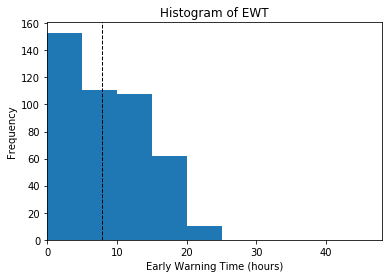

In [20]:
#moving on to part e
g_testOnset = testOnsetini

g_optimalIndex = np.where((g_fpr == g_x_coord) & (g_tpr == g_y_coord))
g_optimalThreshold = g_thresholds[g_optimalIndex][0]

# first, apply model to testing data
g_y_testPred=g_mod.predict(x_testDM)
g_y_testPred[g_y_testPred>g_optimalThreshold]=1

# filter data to find patients with both predicted AND actual y = 1
g_glmTest_filt=glmTest2[['patient','y']]
g_glmTest_filt['y_pred'] = np.array(g_y_testPred)
g_glmTest_filt['TS']=testTSini['x']
g_glmTest_SepticShock=g_glmTest_filt[(g_glmTest_filt['y_pred']==1)&(g_glmTest_filt['y']==1)].groupby('patient').first()
g_glmTest_SepticShock['patient'] =g_glmTest_SepticShock.index

# convert strings to datetime
from datetime import datetime
from dateutil.parser import parse

# concat measurement timestamp to glmTest_SepticShock
g_glmTest_SepticShock['TS']=[i.replace(year=2020,month=10,day=17) for i in [parse(x) for x in g_glmTest_SepticShock['TS'].values]]
#,month=10,day=17

# concat actual onset timestamp to glmTest_SepticShock
g_glmAllSeptic=glmTest2[glmTest2['y']==1].groupby('patient').first()
g_glmAllSeptic['patient'] = g_glmAllSeptic.index
g_glmAllSeptic = g_glmAllSeptic.reset_index(drop=True)
g_testOnset = g_testOnset.reset_index(drop=True)
g_testOnset = g_testOnset.join(g_glmAllSeptic['patient'])
g_glmTest_SepticShock['Onset']=[g_testOnset.iloc[list(np.where(g_testOnset['patient'] == x)[0])[0],1] for x in g_glmTest_SepticShock['patient'].values]
g_glmTest_SepticShock['Onset']=[i.replace(year=2020,month=10,day=17) for i in [parse(x) for x in g_glmTest_SepticShock['Onset'].values]]

# find difference between measurement TS and onset TS
g_glmTest_SepticShock.reset_index(drop=True)
g_glmTest_SepticShock['EWT']=[(g_glmTest_SepticShock.iloc[x,4]-g_glmTest_SepticShock.iloc[x,2]).total_seconds()/(60*60) for x in range(0,len(g_glmTest_SepticShock))]
#glmTest_SepticShock['EWT']=np.where(glmTest_SepticShock['EWT']<0, 0, glmTest_SepticShock['EWT'])
g_glmTest_SepticShock = g_glmTest_SepticShock.drop(g_glmTest_SepticShock[g_glmTest_SepticShock['EWT'] < 0].index)
plt.hist(g_glmTest_SepticShock['EWT'].values,bins=range(0,50,5))
plt.xlim([0,48])
plt.title("Histogram of EWT")
plt.xlabel("Early Warning Time (hours)")
plt.ylabel("Frequency")
plt.axvline(np.median(g_glmTest_SepticShock['EWT'].values), color='k', linestyle='dashed', linewidth=1)
np.median(g_glmTest_SepticShock['EWT'].values)